In [151]:
# !module add p7zip/16.02-gcc/8.4.1
# !wget --header 'Host: doc-08-2g-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/' --header 'Cookie: AUTH_9k7m8g8qrj7at7i0b1sl7f8s8gafrr77_nonce=fchj71prkosgs' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-08-2g-docs.googleusercontent.com/docs/securesc/5baff4djp5n2ak1832to2m6lltldb4gl/lld851i2e7pqe774volddlu45niullkl/1621202400000/00677992938550103544/12785117600840412092/1N1Qx-R5tLCX5EhXPoPdyg6YvEkDtf-cD?e=download&authuser=0&nonce=fchj71prkosgs&user=12785117600840412092&hash=0lccq4nigav75jop1timeo66ook4s4q1' --output-document 'ANTs-28-03-2019.7z'
# !7z x ANTs-28-03-2019.7z
# !cp bin/* /home/rgoli/.local/bin

In [152]:
import tensorflow as tf
import random
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate,Dropout, Dense, GlobalAveragePooling3D, MaxPool3D
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [153]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow

#import SimpleITK as sitk
# from nilearn.image import math_img
# from nilearn import image as nii
# from nilearn import plotting
# from nipype.interfaces.ants import N4BiasFieldCorrection
# from nilearn.image import resample_img

In [154]:
DATA_FOLDER = "data/BET_BSE_DATA/"

In [155]:
img=nib.load(DATA_FOLDER+'files/IXI662-Guys-1120-T1_bse_less_s46_r1.nii.gz')
print('Shape of image=',img.shape)

Shape of image= (256, 256, 150)


In [156]:
mri_image_files = os.listdir(DATA_FOLDER+'/files')

In [157]:
print(mri_image_files[0:10])

['IXI607-Guys-1097-T1_bse_high_s75_r2.nii.gz', 'IXI002-Guys-0828-T1_bse_less_s5_r1.nii.gz', 'IXI051-HH-1328-T1_bet_75.nii.gz', 'IXI490-Guys-1018-T1_bse_high_s75_r2.nii.gz', 'IXI067-HH-1356-T1_bse_high_s81_r2.nii.gz', 'IXI544-HH-2395-T1_bse_high_s87_r2.nii.gz', 'IXI025-Guys-0852-T1_bet_14.nii.gz', 'IXI496-Guys-1045-T1_bse_high_s89_r2.nii.gz', 'IXI462-IOP-1042-T1_bse_less_s45_r1.nii.gz', 'IXI016-Guys-0697-T1_bet_17.nii.gz']


In [158]:
labels = pd.read_csv(DATA_FOLDER+'Label_file.csv')
labels['Filename'] = DATA_FOLDER+'files/'+labels['Filename'].astype(str)+'.gz'
labels.loc[labels['Recognizable-Facial-Feature'] == 'Yes', 'Recognizable-Facial-Feature'] = 1
labels.loc[labels['Recognizable-Facial-Feature'] == 'No', 'Recognizable-Facial-Feature'] = 0
labels.loc[labels['Brain-Feature-Loss'] == 'Yes', 'Brain-Feature-Loss'] = 1
labels.loc[labels['Brain-Feature-Loss'] == 'No', 'Brain-Feature-Loss'] = 0
# labels['Brain-Feature-Loss'] = labels['Brain-Feature-Loss'].astype(int)

In [159]:
labels.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,data/BET_BSE_DATA/files/IXI369-Guys-0924-T1_be...,1,0
1,data/BET_BSE_DATA/files/IXI448-HH-2393-T1_bet_...,1,0
2,data/BET_BSE_DATA/files/IXI252-HH-1693-T1_bet_...,1,0
3,data/BET_BSE_DATA/files/IXI188-Guys-0798-T1_be...,1,0
4,data/BET_BSE_DATA/files/IXI182-Guys-0792-T1_be...,1,0


In [160]:
labels.shape

(1311, 3)

In [161]:
labels.iloc[1]['Filename']

'data/BET_BSE_DATA/files/IXI448-HH-2393-T1_bet_07.nii.gz'

/local_scratch/pbs.4659211.pbs02/ipykernel_2393736/2273036769.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(labels.iloc[i]['Filename']).get_data()


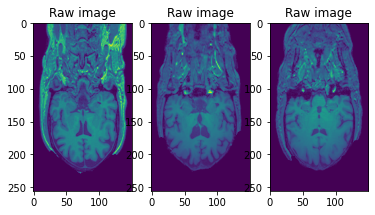

In [162]:
#lets visualize a couple of examples
fig,ax=plt.subplots(1,3)
for i in range(3):
    ax[i].set_title('Raw image')
    img = nib.load(labels.iloc[i]['Filename']).get_data()
    ax[i].imshow(img[img.shape[0]//2])

In [163]:
## Bias Correction
# n4 = N4BiasFieldCorrection()
# n4.inputs.dimension = 3
# n4.inputs.shrink_factor = 3
# n4.inputs.n_iterations = [20, 10, 10, 5]

# # !mkdir data/BET_BSE_DATA/bias_correction

# index_corr=[]
# for i in tqdm(range(len(mri_image_files))):
#     file_name = mri_image_files[i]
#     n4.inputs.input_image = file_name
#     n4.inputs.output_image ='data/BET_BSE_DATA/bias_correction/'+file_name+'.gz'
#     index_corr.append('data/BET_BSE_DATA/bias_correction/'+file_name+'.gz')
#     res = n4.run()

# #index_corr=['data/BET_BSE_DATA/bias_correction/'+str(i)+'.nii.gz' for i in range(125)]
# #data['bias_corr']=index_corr
# print('Bias corrected images stored at : data/BET_BSE_DATA/bias_correction/')

In [164]:
# !module list

In [165]:
# !module add ant/1.9.6-gcc/8.3.1

In [166]:
from sklearn.model_selection import train_test_split

class model():
    def __init__(self,):
        pass
    
    def split(self,df):
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(df[['Filename']], df[['Recognizable-Facial-Feature']],test_size=0.2)
        return self.X_train,self.X_test,self.y_train,self.y_test

    def data_gen(self,images, targets, batch_size):
        '''Custom data generator to feed image to model'''
        c = 0
        n = [i for i in range(len(images))]  #List of training images
        random.shuffle(n)
    
        while (True):
            img = np.zeros((batch_size, 256, 256, 150,1)).astype('float')   #adding extra dimensions as conv3d takes file of size 5
            tgt = np.zeros((batch_size)).astype('float')
            
            for i in range(c, c+batch_size): 
                train_img = nib.load(images[n[i]]).get_data()
                train_img=np.expand_dims(train_img,-1)
                img[i-c]=train_img
                tgt[i-c]=targets[n[i]]

            c+=batch_size
            if(c+batch_size>=len(img_list)):
                c=0
                random.shuffle(n)

            yield img,tgt

    def convolutional_block(self,inp, filters=3, kernel_size=3, batchnorm = True):
        '''conv layer followed by batchnormalization'''
        x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
                   kernel_initializer = 'he_normal', padding = 'same')(inp)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
                   kernel_initializer = 'he_normal', padding = 'same')(inp)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x) 
        return x
    
    def resunet_opt(self,input_img, filters = 64, dropout = 0.2, batchnorm = True):
        
        """Residual Unet + Dense Atrous convolution + Rmp block"""
        # 256x256x150
        conv1 = self.convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
        pool1 = MaxPooling3D((2, 2, 2))(conv1)
        drop1 = Dropout(dropout)(pool1)
        
        # 128x128x75
        conv2 = self.convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
        pool2 = MaxPooling3D((2, 2, 2))(conv2)
        drop2 = Dropout(dropout)(pool2)
        
        # 64x64x37
        conv3 = self.convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
        pool3 = MaxPooling3D((2, 2, 2))(conv3)
        drop3 = Dropout(dropout)(pool3)
        
        # 32x32x18
        conv4 = self.convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
        pool4 = MaxPooling3D((2, 2, 2))(conv4)
        drop4 = Dropout(dropout)(pool4)

        # 16x16x9
        conv5 = self.convolutional_block(drop4, filters * 16, kernel_size = 3, batchnorm = False)
        pool5 = MaxPooling3D((2, 2, 2))(conv5)
        drop5 = Dropout(dropout)(pool5) 
        
        # 8x8x4
        avgpool = GlobalAveragePooling3D()(drop5)
        dense1 = Dense(units=512, activation="relu")(avgpool)
        drop6 = Dropout(0.3)(dense1)
        
        outputs = Dense(units=1, activation="sigmoid")(drop6)
        
        model = Model(inputs=[input_img], outputs=outputs, name="3dcnn")
        
        return model
    
    def training(self,epochs):
        im_height=256
        im_width=256
        img_depth=150
        epochs=60
        train_gen = self.data_gen(self.X_train,self.y_train, batch_size = 4)
        val_gen = self.data_gen(self.X_test,self.y_test, batch_size = 4)
        channels=1
        input_img = Input((im_height, im_width,img_depth,channels), name='img')
        self.model = self.resunet_opt(input_img, filters=16, dropout=0.05, batchnorm=True)
        self.model.summary()
        self.model.compile(optimizer=Adam(lr=1e-1),loss="binary_crossentropy",metrics=['accuracy'])
        #fitting the model
        callbacks=callbacks = [
            ModelCheckpoint('data/best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)]
        result=self.model.fit(train_gen,steps_per_epoch=16,epochs=epochs,validation_data=val_gen,validation_steps=16,initial_epoch=0,callbacks=callbacks)
        
    def inference(self,img_path):
        '''Generates prediction for a sample image and does the plotting'''

        #getting predictions 
        orig_img=nib.load(img_path).get_data()
        orig_img=np.expand_dims(orig_img,-1)
        orig_img=np.expand_dims(orig_img,0)
        
        model=keras.models.load_model('data/new_best.h5',custom_objects={'categorical_crossentropy_plus_dice_loss''iou_score':iou_score})
        pred=model.predict(orig_img)
        print("Prediction: {}".format(pred))
        
        #plotting outputs
        fig,ax=plt.subplots(1,1,figsize=(15,10))
        ax[0].set_title('Original image (cropped)')
        ax[0].imshow(orig_img[orig_img.shape[0]//2])

    def plotting(self,filepath):
        '''Plots an interactive plot'''
        img=nii.mean_img(filepath)
        plotting.view_img(img,bg_img=img)

In [167]:
labels.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,data/BET_BSE_DATA/files/IXI369-Guys-0924-T1_be...,1,0
1,data/BET_BSE_DATA/files/IXI448-HH-2393-T1_bet_...,1,0
2,data/BET_BSE_DATA/files/IXI252-HH-1693-T1_bet_...,1,0
3,data/BET_BSE_DATA/files/IXI188-Guys-0798-T1_be...,1,0
4,data/BET_BSE_DATA/files/IXI182-Guys-0792-T1_be...,1,0


In [168]:
nn=model()
X_train,X_test,y_train,y_test=nn.split(labels)

In [169]:
nn.training(10)

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 150, 1) 0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 256, 256, 150, 16) 448       
_________________________________________________________________
batch_normalization_41 (Batc (None, 256, 256, 150, 16) 64        
_________________________________________________________________
activation_51 (Activation)   (None, 256, 256, 150, 16) 0         
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 128, 128, 75, 16)  0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 128, 128, 75, 16)  0         
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 128, 128, 75, 32)  13856 

KeyError: 620